# 2. Prepare Data

From https://machinelearningmastery.com/process-for-working-through-machine-learning-problems/

I preface data preparation with a data analysis phase that involves summarizing the attributes and visualizing them using scatter plots and histograms. I also like to describe in detail each attribute and relationships between attributes. This grunt work forces me to think about the data in the context of the problem before it is lost to the algorithms

The actual data preparation process is three step as follows:

* Step 1: Data Selection: Consider what data is available, what data is missing and what data can be removed.
* Step 2: Data Preprocessing: Organize your selected data by formatting, cleaning and sampling from it.
* Step 3: Data Transformation: Transform preprocessed data ready for machine learning by engineering features using scaling, attribute decomposition and attribute aggregation.


## Update 15/5/2019

### Changes from last session:

Currently working on 2-prepare-data.ipynb.

We have been working on finding correlations between 1 target indicator for a country and other indicators in that same country.
* Plotting one target indicator [Environmental Sustainability (7.8)] for Afghanistan.
* Plotting all indicators except Environmental Sustainability (7.8) for Afghanistan.
* Plotting all indicators except Environmental Sustainability (7.8) for Afghanistan for 2001 to 2007.
* Enlisting top correlated features against target feature [Environmental Sustainability (7.8)].
* Plotting the top correlated indicators for Afghanisthan between 2000 to 2007.

### Next steps

* To predict one indicator, we can maybe use indicators on the similar goal, or the indicators from close countries (can use our continent column that we added). This needs to be determined.
* Improve our model training, by testing it on the training data and evaluating the accuracy of the model.
* Rerun predictions using correlations explored above and see if they improve our results.
* We could use a more sophisticated model than linear regression to improve the accuracy of our model. Should we try polynomial for a start?
* Find out what to do with missing data. Should we drop them or fill them?

### What we have learned so far

* We can problem frame this as a regression problem. Given N years of data for a metric, predict next year.
* The series name and series code are perfectly correlated, we can drop the series name with no loss of data.
* The series codes show a hierarchy and we can use sub codes to filter series by common goal.
* The first column in the training and submission sets is a row ID that we can use to join the two datasets.
* If we consider only the joined dataset then we have a much higher proportion of year data for series than the dataset as a whole. We also only need to predict values for 737 series/country combinations out of the 195402 present in the training set.
* By applying linear regression to our series, we can already get some reasonable results for some indicators.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [2]:
# expands columns to maximum width
pd.set_option('display.max_colwidth', -1)

In [3]:
from sklearn.linear_model import LinearRegression

## Retrieve resources

The data directory will be ignored by `git` and you will need to retrieve manually the resources.

You can retrieve the contents of [the zip file from the AWS link](https://s3.amazonaws.com/drivendata/data/1/public/cd238763-ed29-4a46-8584-f9334d57ec94.zip) and place them into the data subdirectory. You should have `data/TrainingSet.csv` and `data/SubmissionRows.csv`.

You will need to put the `countryinfo.py` file in the data / folder  as well. Here is the [link to retrieve country info data](https://gist.githubusercontent.com/pamelafox/986163/raw/f5f9db4f1b287804fd07ffb3296ed0036292bc7a/countryinfo.py).

## Training Set

In [4]:
df = pd.read_csv("data/TrainingSet.csv")

In [5]:
# look at the first few lines to get an idea what the actual data look like
df.head(2)

,Unnamed: 0,1972 [YR1972],1973 [YR1973],1974 [YR1974],1975 [YR1975],1976 [YR1976],1977 [YR1977],1978 [YR1978],1979 [YR1979],1980 [YR1980],...,2001 [YR2001],2002 [YR2002],2003 [YR2003],2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007],Country Name,Series Code,Series Name
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.769214,Afghanistan,allsi.bi_q1,(%) Benefits held by 1st 20% population - All Social Insurance
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7.027746,Afghanistan,allsp.bi_q1,(%) Benefits held by 1st 20% population - All Social Protection


In [6]:
# last few lines
df.tail(2)

,Unnamed: 0,1972 [YR1972],1973 [YR1973],1974 [YR1974],1975 [YR1975],1976 [YR1976],1977 [YR1977],1978 [YR1978],1979 [YR1979],1980 [YR1980],...,2001 [YR2001],2002 [YR2002],2003 [YR2003],2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007],Country Name,Series Code,Series Name
195400,286116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,24.3,NaN,Zimbabwe,SG.VAW.REFU.ZS,Women who believe a husband is justified in beating his wife when she refuses sex with him (%)
195401,286117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,57.0,57.2,57.5,57.7,57.9,58.1,58.3,Zimbabwe,SH.DYN.AIDS.FE.ZS,Women's share of population ages 15+ living with HIV (%)


The first column looks like a row ID, let's double check to see if that's the case.

In [7]:
df.iloc[:,0].nunique() == df.shape[0]

True

There are as many unique rows in the index column as in the row dataframe dimension, so I'm going to use `index_col=0`.

In [8]:
df = pd.read_csv('data/TrainingSet.csv', index_col=0)

In [9]:
df.head(3)

,1972 [YR1972],1973 [YR1973],1974 [YR1974],1975 [YR1975],1976 [YR1976],1977 [YR1977],1978 [YR1978],1979 [YR1979],1980 [YR1980],1981 [YR1981],...,2001 [YR2001],2002 [YR2002],2003 [YR2003],2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007],Country Name,Series Code,Series Name
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.769214,Afghanistan,allsi.bi_q1,(%) Benefits held by 1st 20% population - All Social Insurance
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7.027746,Afghanistan,allsp.bi_q1,(%) Benefits held by 1st 20% population - All Social Protection
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,8.244887,Afghanistan,allsa.bi_q1,(%) Benefits held by 1st 20% population - All Social Safety Nets


In [10]:
# what are the column names?
df.columns

Index(['1972 [YR1972]', '1973 [YR1973]', '1974 [YR1974]', '1975 [YR1975]',
       '1976 [YR1976]', '1977 [YR1977]', '1978 [YR1978]', '1979 [YR1979]',
       '1980 [YR1980]', '1981 [YR1981]', '1982 [YR1982]', '1983 [YR1983]',
       '1984 [YR1984]', '1985 [YR1985]', '1986 [YR1986]', '1987 [YR1987]',
       '1988 [YR1988]', '1989 [YR1989]', '1990 [YR1990]', '1991 [YR1991]',
       '1992 [YR1992]', '1993 [YR1993]', '1994 [YR1994]', '1995 [YR1995]',
       '1996 [YR1996]', '1997 [YR1997]', '1998 [YR1998]', '1999 [YR1999]',
       '2000 [YR2000]', '2001 [YR2001]', '2002 [YR2002]', '2003 [YR2003]',
       '2004 [YR2004]', '2005 [YR2005]', '2006 [YR2006]', '2007 [YR2007]',
       'Country Name', 'Series Code', 'Series Name'],
      dtype='object')

Let's rename the columns to remove gaps and unnecessary info and to ease further coding when selecting the sets of columns.

In [11]:
df.columns = [year[:4] for year in df.columns][:-3] + [col.replace(' ', '_') for col in df.columns.values[-3:]]

In [12]:
# some basic stats about the training data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
1972,64945.0,1.630638e+11,4.261616e+12,-1.047939e+14,3.176702,63.940000,5.007000e+06,2.681335e+14
1973,64443.0,1.839488e+11,4.749746e+12,-1.128889e+14,3.550009,66.317365,7.131000e+06,2.943467e+14
1974,64966.0,2.089534e+11,5.378336e+12,-7.134161e+13,4.000000,70.485627,9.250000e+06,3.186506e+14
1975,66973.0,2.148826e+11,5.647070e+12,-8.269588e+13,3.671917,71.886131,1.108200e+07,3.383541e+14
1976,67717.0,2.321517e+11,6.120314e+12,-9.735652e+13,4.595300,74.563536,1.290000e+07,3.586152e+14
1977,69735.0,2.413682e+11,6.398377e+12,-9.433422e+13,5.000000,78.944621,1.540950e+07,3.895869e+14
1978,69763.0,2.540583e+11,6.710724e+12,-9.495898e+13,4.901495,78.638080,1.922850e+07,4.254506e+14
1979,69906.0,2.742810e+11,7.213662e+12,-5.362479e+13,5.000000,81.408655,2.409375e+07,4.556262e+14
1980,75250.0,2.674858e+11,7.381164e+12,-5.649790e+13,5.682373,81.829695,2.419225e+07,5.039050e+14
1981,78034.0,2.774415e+11,7.942777e+12,-5.437839e+13,5.000000,78.137173,2.317875e+07,5.815794e+14


In [13]:
# list of unique countries
df.Country_Name.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra',
       'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas, The', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon',
       'Canada', 'Cayman Islands', 'Central African Republic', 'Chad',
       'Channel Islands', 'Chile', 'China', 'Colombia', 'Comoros',
       'Congo, Dem. Rep.', 'Congo, Rep.', 'Costa Rica', "Cote d'Ivoire",
       'Croatia', 'Cuba', 'Curacao', 'Cyprus', 'Czech Republic',
       'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador',
       'Egypt, Arab Rep.', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Ethiopia', 'Faeroe Islands', 'Fiji', 'Finland',
       'France', 

In [14]:
print(f'Number of distinct countries: {df.Country_Name.nunique()}')

Number of distinct countries: 214


In [15]:
# number of unique values in each column
df.nunique()

1972            47534 
1973            47677 
1974            48521 
1975            50269 
1976            51279 
1977            53185 
1978            53578 
1979            53882 
1980            58032 
1981            59693 
1982            60516 
1983            60615 
1984            61088 
1985            62170 
1986            62726 
1987            63482 
1988            63814 
1989            65248 
1990            78732 
1991            77506 
1992            80642 
1993            81969 
1994            83600 
1995            88951 
1996            89206 
1997            90177 
1998            90256 
1999            94957 
2000            99186 
2001            99397 
2002            102167
2003            101224
2004            102863
2005            111682
2006            112989
2007            115182
Country_Name    214   
Series_Code     1305  
Series_Name     1305  
dtype: int64

In [16]:
# percentage of non-nul data in each column
(df.count() / df.shape[0] * 100).map('{:.1f}%'.format)

1972            33.2% 
1973            33.0% 
1974            33.2% 
1975            34.3% 
1976            34.7% 
1977            35.7% 
1978            35.7% 
1979            35.8% 
1980            38.5% 
1981            39.9% 
1982            40.4% 
1983            40.4% 
1984            40.7% 
1985            41.5% 
1986            41.7% 
1987            42.3% 
1988            42.6% 
1989            44.2% 
1990            54.7% 
1991            54.8% 
1992            57.4% 
1993            58.6% 
1994            59.8% 
1995            63.7% 
1996            63.7% 
1997            64.3% 
1998            64.5% 
1999            67.0% 
2000            71.9% 
2001            70.0% 
2002            71.8% 
2003            71.2% 
2004            72.9% 
2005            82.7% 
2006            81.3% 
2007            82.7% 
Country_Name    100.0%
Series_Code     100.0%
Series_Name     100.0%
dtype: object

## Submission data

In [17]:
# read the data containing the rows we need to predict
df_submission = pd.read_csv('data/SubmissionRows.csv', index_col=0)

In [18]:
df_submission.head(10)

,2008 [YR2008],2012 [YR2012]
559,NaN,NaN
618,NaN,NaN
753,NaN,NaN
1030,NaN,NaN
1896,NaN,NaN
1955,NaN,NaN
2090,NaN,NaN
2690,NaN,NaN
3233,NaN,NaN
3292,NaN,NaN


In [19]:
df_submission.shape

(737, 2)

As we have the row ID as an index for both the training (df) and the submission data, we can directly extract the data related to the submission index.

In [20]:
df_submission_in_data = df.loc[df_submission.index]

In [21]:
df_submission_in_data.Country_Name.nunique()

206

Let's have a look at the Series Codes in the submission data.

In [22]:
submission_codes = df_submission_in_data.Series_Code.unique()

In [23]:
print(f'List of unique submission codes: {list(submission_codes)}')
print(f'Number of unique submission codes: {len(submission_codes)}')

List of unique submission codes: ['7.8', '8.16', '4.1', '6.1', '2.1', '5.1', '6.7']
Number of unique submission codes: 7


In [24]:
print(f'Number of submission codes in Series Code column: {df.Series_Code.isin(submission_codes).sum()}')

Number of submission codes in Series Code column: 1118


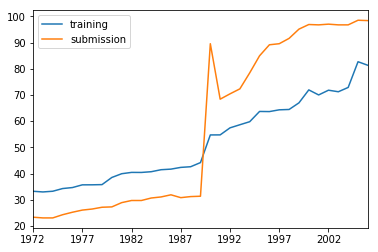

In [25]:
# plots of the percentage of non-null data in each column
(df.count() / df.shape[0] * 100).iloc[:-4].plot(label='training')
(df_submission_in_data.count() / df_submission_in_data.shape[0] * 100).iloc[:-4].plot(label='submission')
plt.legend();

We have learned from the analysis of the submission data that:
1. Most countries are represented in the submission data, 206 out of 214.
2. Only 7 codes are used and we have 1118 data points in the training data with these codes.
3. The amount of missing data is fairly similar between the training and submission data.

# What are we trying to achieve?

 * We have 737 indicators from 206 countries with data from 1972 to 2007. We would like to predict what these indicators will be in 2008 and 2012.

 * A very simplistic way of predicting the future values of these indicators would be to do a simple linear regression for indicators with more than 1 data point in the last 35 years or use the only data point we have for indicators with a single value.

 * **Let's try to code this simplistic version.**

In [26]:
# calculates linear regression on non-null values and produces predictions for 2008 and 2012
def calculate_prediction(row):
    data = row.loc['1972':'2007']
    if data.count() < 2:
        pred_2008 = data.dropna().values
        pred_2012 = pred_2008
    else:
        years = data.dropna().index.values.astype(np.int).reshape(-1, 1)
        values = data.dropna().values.reshape(-1, 1)

        regr = LinearRegression()
        regr.fit(years, values)

        years_pred = np.array((2008, 2012)).reshape(-1, 1)
        pred_2008, pred_2012 = regr.predict(years_pred)

    return pred_2008[0], pred_2012[0]

In [27]:
df_simple_preds = pd.DataFrame(df_submission_in_data.apply(calculate_prediction, axis=1).tolist(), \
                               index=df_submission_in_data.index, columns=['2008','2012'])

In [28]:
df_simple_preds.head()

,2008,2012
559,0.465706,0.580451
618,0.012712,0.016830
753,0.087664,0.065155
1030,0.001000,0.001000
1896,0.961802,0.960782


Let's visualise the results:

In [29]:
def plot_predictions(df_train, df_pred, nrows):
    rows_to_plot = np.random.choice(df_train.index.values, nrows, replace=False)
    
    cmap = get_cmap('Set2')
    colors = cmap.colors
        
    fig, ax = plt.subplots(figsize=(12,10))
    for i, j in zip(rows_to_plot, range(nrows)):
        j = j % len(colors)  # allows rotation through color map
        ax.plot(df_train.loc[i, '1972':'2007'].dropna().index.astype(int), 
                df_train.loc[i, '1972':'2007'].dropna().values, 
                label=df_train.loc[i, 'Country_Name']+ ' / ' + df_train.loc[i, 'Series_Name'],
                marker='o',
                linewidth=4,
                alpha=0.5,
                color=colors[j])
                
        ax.plot(df_pred.loc[i].index.astype(int), 
                df_pred.loc[i].values,
                marker='s',
                linewidth=4,
                markersize=10,
                color=colors[j])

    plt.legend(loc='best')

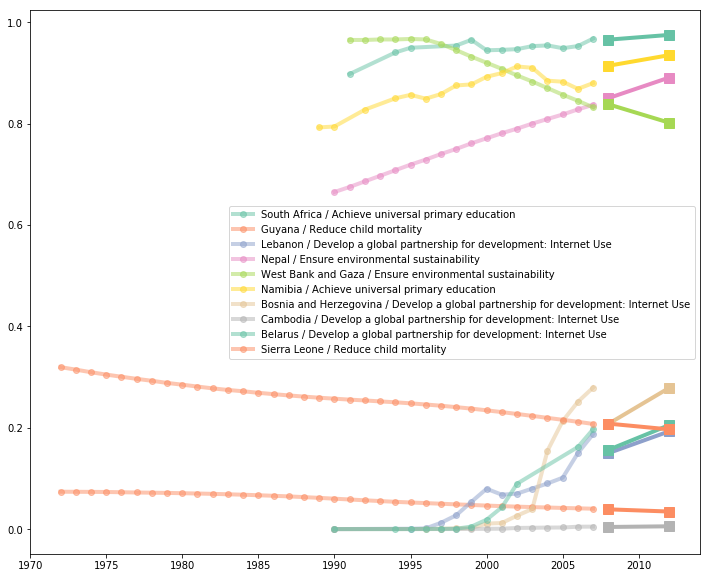

In [30]:
plot_predictions(df_submission_in_data, df_simple_preds, 10)

These results are simplistic but not too bad for most indicators. We could improve easily the results by doing a polynomial regression or another type of more sophisticated regression.  

What we are trying to achieve is finding correlation between these indicators and all the other indicators present in the dataset to improve our predictions as we have a lot of missing data.

These predictions using correlations are where the difficulty of this exercise lies.

## Separating sub codes from the main code values

Let's first make all values upper case to make sure we compare correctly the codes

In [31]:
df.Series_Code = df.Series_Code.str.upper()

In [32]:
df.Series_Code.nunique()

1305

 * We have 1305 different code names but most of them include similar codes which might be helpful when trying to find similarity within the data to help with our predictions.  
 * We will create a function that extract each of the subcodes and save them in separate column in function of their order in the code serie.

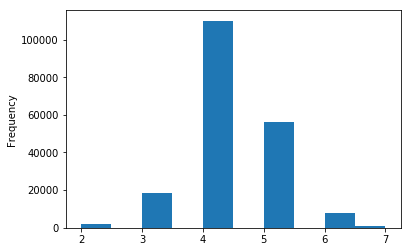

In [33]:
# Exploring the code structure
df.Series_Code.apply(lambda x: len(x.split('.'))).plot(kind='hist');

In [34]:
# what are the most common series codes in the 'Series Code' column
df.Series_Code.str.split('.').value_counts(ascending=False)[:10]

[SP, POP, TOTL]            214
[SP, POP, GROW]            214
[NY, ADJ, DNGY, CD]        214
[NY, ADJ, DMIN, CD]        214
[AG, LND, TOTL, K2]        213
[AG, SRF, TOTL, K2]        213
[EN, POP, DNST]            213
[SP, URB, GROW]            210
[SP, URB, TOTL, IN, ZS]    210
[SP, RUR, TOTL]            210
Name: Series_Code, dtype: int64

In [35]:
row_longest_code_serie = df.Series_Code.apply(lambda x: len(x.split('.'))).idxmax()
df.loc[row_longest_code_serie, 'Series_Code']

'SL.EMP.TOTL.SP.FE.NE.ZS'

In [36]:
len(df.loc[row_longest_code_serie, 'Series_Code'].split('.'))

7

We have a maximum of 7 separate elements in the code structure

In [37]:
def explode_code(s):
    # split the code name using the '.'
    s_split = s.split('.')
    
    # save the first and last value of the serie
    last = s_split[-1]
    first = s_split[0]
    
    # reverse the order of the code series to keep the last code as first and first as last
    #s_split = s_split[::-1]
    
    # add NaN values until the list has 7 items in it
    s_split += [np.NaN] * (7 - len(s_split))
    
    # add the first and last value to the list
    s_split += [first, last]
    
    return s_split

In [38]:
# We first create 9 new columns for each output of the function explode_code. We then
# fill these columns with the ouput of the explode_code function by converting its
# ouput to a list and then to a dataframe using the orginal dataframe index.

df[['Series_Code_'+ str(i) for i in range(7)] + ['Series_Code_First', 'Series_Code_Last']] =\
    pd.DataFrame(df.Series_Code.apply(explode_code).tolist(), index=df.index)

In [39]:
df.iloc[:5,-11:]

,Series_Code,Series_Name,Series_Code_0,Series_Code_1,Series_Code_2,Series_Code_3,Series_Code_4,Series_Code_5,Series_Code_6,Series_Code_First,Series_Code_Last
0,ALLSI.BI_Q1,(%) Benefits held by 1st 20% population - All Social Insurance,ALLSI,BI_Q1,NaN,NaN,NaN,NaN,NaN,ALLSI,BI_Q1
1,ALLSP.BI_Q1,(%) Benefits held by 1st 20% population - All Social Protection,ALLSP,BI_Q1,NaN,NaN,NaN,NaN,NaN,ALLSP,BI_Q1
2,ALLSA.BI_Q1,(%) Benefits held by 1st 20% population - All Social Safety Nets,ALLSA,BI_Q1,NaN,NaN,NaN,NaN,NaN,ALLSA,BI_Q1
4,ALLSI.GEN_POP,(%) Generosity of All Social Insurance,ALLSI,GEN_POP,NaN,NaN,NaN,NaN,NaN,ALLSI,GEN_POP
5,ALLSP.GEN_POP,(%) Generosity of All Social Protection,ALLSP,GEN_POP,NaN,NaN,NaN,NaN,NaN,ALLSP,GEN_POP


In [40]:
df.iloc[-5:,-11:]

,Series_Code,Series_Name,Series_Code_0,Series_Code_1,Series_Code_2,Series_Code_3,Series_Code_4,Series_Code_5,Series_Code_6,Series_Code_First,Series_Code_Last
286113,SG.VAW.BURN.ZS,Women who believe a husband is justified in beating his wife when she burns the food (%),SG,VAW,BURN,ZS,NaN,NaN,NaN,SG,ZS
286114,SG.VAW.GOES.ZS,Women who believe a husband is justified in beating his wife when she goes out without telling him (%),SG,VAW,GOES,ZS,NaN,NaN,NaN,SG,ZS
286115,SG.VAW.NEGL.ZS,Women who believe a husband is justified in beating his wife when she neglects the children (%),SG,VAW,NEGL,ZS,NaN,NaN,NaN,SG,ZS
286116,SG.VAW.REFU.ZS,Women who believe a husband is justified in beating his wife when she refuses sex with him (%),SG,VAW,REFU,ZS,NaN,NaN,NaN,SG,ZS
286117,SH.DYN.AIDS.FE.ZS,Women's share of population ages 15+ living with HIV (%),SH,DYN,AIDS,FE,ZS,NaN,NaN,SH,ZS


## Adding the continent related to each country

In [41]:
from data import countryinfo

In [42]:
df_continent = pd.DataFrame(countryinfo.countries)

In [43]:
df_continent.head()

,capital,code,continent,name,timezones
0,Andorra la Vella,AD,Europe,Andorra,[Europe/Andorra]
1,Kabul,AF,Asia,Afghanistan,[Asia/Kabul]
2,St. John's,AG,North America,Antigua and Barbuda,[America/Antigua]
3,Tirana,AL,Europe,Albania,[Europe/Tirane]
4,Yerevan,AM,Asia,Armenia,[Asia/Yerevan]


In [44]:
df_continent.shape

(193, 5)

In [45]:
df_continent.columns

Index(['capital', 'code', 'continent', 'name', 'timezones'], dtype='object')

We copy the continent information from the dataframe using the country names as index.

In [46]:
# We use the map function in pandas to look for the country name in 
# the index of the second df and output the continent information.
df['Continent'] = df.Country_Name.map(df_continent.set_index('name').continent)

In [47]:
df[['Continent','Country_Name']].iloc[::15000]

,Continent,Country_Name
0,Asia,Afghanistan
22951,Europe,Belarus
42230,NaN,Cabo Verde
63269,Europe,Croatia
85989,Oceania,Fiji
108623,North America,Haiti
129577,Asia,Jordan
153088,NaN,"Macao SAR, China"
174444,Europe,Montenegro
196608,North America,Panama


We have some countries with names that are different from our list of country/continent

In [48]:
df[df.Continent.isna()].Country_Name.unique()

array(['American Samoa', 'Aruba', 'Bahamas, The', 'Bermuda', 'Cabo Verde',
       'Cayman Islands', 'Channel Islands', 'China', 'Congo, Dem. Rep.',
       'Congo, Rep.', "Cote d'Ivoire", 'Curacao', 'Egypt, Arab Rep.',
       'Faeroe Islands', 'French Polynesia', 'Gambia, The', 'Greenland',
       'Guam', 'Hong Kong SAR, China', 'Iran, Islamic Rep.', 'Ireland',
       'Isle of Man', 'Korea, Dem. Rep.', 'Korea, Rep.', 'Kosovo',
       'Kyrgyz Republic', 'Lao PDR', 'Macao SAR, China', 'Macedonia, FYR',
       'Micronesia, Fed. Sts.', 'Netherlands', 'New Caledonia',
       'Northern Mariana Islands', 'Puerto Rico', 'Russian Federation',
       'Sao Tome and Principe', 'Sint Maarten (Dutch part)',
       'Slovak Republic', 'South Sudan', 'St. Kitts and Nevis',
       'St. Lucia', 'St. Martin (French part)',
       'St. Vincent and the Grenadines', 'Syrian Arab Republic',
       'Timor-Leste', 'Turks and Caicos Islands', 'Venezuela, RB',
       'Virgin Islands (U.S.)', 'West Bank and Gaza', 

In [49]:
df[df.Country_Name.str.contains('Bahamas', case=False)].Country_Name.unique()

array(['Bahamas, The'], dtype=object)

In [50]:
df_continent[df_continent.name.str.contains('Bahamas', case=False)]

,capital,code,continent,name,timezones
21,Nassau,BS,North America,Bahamas,[America/Nassau]


### Missing continent values

Let's do some fuzzy matching to find the most likely candidate for the country listed in our database.

In [51]:
from fuzzywuzzy import fuzz, process

In [52]:
country_bad_name = df[df.Continent.isna()].Country_Name.unique()
countries = df_continent.name.values

In [53]:
country = country_bad_name[0]
print(country)
process.extractOne(country, countries)

American Samoa


('Samoa', 90)

In [54]:
df_fuzzy = pd.DataFrame([[country]+list(process.extractOne(country, countries)) for country in country_bad_name], 
                        columns=['training_name', 'replacement_name', 'score'])

In [55]:
df_fuzzy.head()

,training_name,replacement_name,score
0,American Samoa,Samoa,90
1,Aruba,Barbados,72
2,"Bahamas, The",Bahamas,90
3,Bermuda,Peru,68
4,Cabo Verde,Cape Verde,80


In [60]:
# Let's add the continent to this dataframe
df_fuzzy['Continent'] = df_fuzzy.replacement_name.map(df_continent.set_index('name').continent)

In [61]:
df_fuzzy.head()

,training_name,replacement_name,score,Continent
0,American Samoa,Samoa,90,Oceania
1,Aruba,Barbados,72,North America
2,"Bahamas, The",Bahamas,90,North America
3,Bermuda,Peru,68,South America
4,Cabo Verde,Cape Verde,80,Africa


In [62]:
# Replacement_name that we are most sure about
df_fuzzy[df_fuzzy.score > 86]

,training_name,replacement_name,score,Continent
0,American Samoa,Samoa,90,Oceania
2,"Bahamas, The",Bahamas,90,North America
7,China,People's Republic of China,90,Asia
10,Cote d'Ivoire,CÃ´te d'Ivoire,96,Africa
12,"Egypt, Arab Rep.",Egypt,90,Africa
15,"Gambia, The",The Gambia,95,Africa
19,"Iran, Islamic Rep.",Iran,90,Asia
20,Ireland,Republic of Ireland,90,Europe
28,"Macedonia, FYR",Macedonia,90,Europe
30,Netherlands,Kingdom of the Netherlands,90,Europe


In [64]:
# Replacement_name that we are not too sure about
df_fuzzy[df_fuzzy.score < 86]

,training_name,replacement_name,score,Continent
1,Aruba,Barbados,72,North America
3,Bermuda,Peru,68,South America
4,Cabo Verde,Cape Verde,80,Africa
5,Cayman Islands,Solomon Islands,69,Oceania
6,Channel Islands,Marshall Islands,71,Oceania
11,Curacao,Cuba,68,North America
13,Faeroe Islands,Marshall Islands,67,Oceania
14,French Polynesia,France,60,Europe
16,Greenland,Grenada,75,North America
17,Guam,Nicaragua,77,North America


We are missing a few easy fixes like Congo and Korea.

Let's fill in the missing continents using the above rule.

In [65]:
countries_to_correct = df.Country_Name.isin(df_fuzzy[df_fuzzy.score > 86].training_name)

df.loc[countries_to_correct, 'Continent'] =\
    df.loc[countries_to_correct, 'Country_Name'].map(
        df_fuzzy[df_fuzzy.score > 86].set_index('training_name').Continent)

#### Let's redo the above fuzzy matching but trying a different metric to catch more missing values

In [66]:
country_bad_name = df[df.Continent.isna()].Country_Name.unique()
countries = df_continent.name.values

In [67]:
country = country_bad_name[5]
print(country)
print(process.extractOne(country, countries))
print(process.extractOne(country, countries, scorer=fuzz.ratio))
print(process.extractOne(country, countries, scorer=fuzz.partial_ratio))
print(process.extractOne(country, countries, scorer=fuzz.token_sort_ratio))
print(process.extractOne(country, countries, scorer=fuzz.token_set_ratio))
print(process.extractOne(country, countries, scorer=fuzz.partial_token_set_ratio))

Congo, Dem. Rep.
('Democratic Republic of the Congo', 86)
("CÃ´te d'Ivoire", 48)
('Togo', 75)
('Republic of the Congo', 59)
('Republic of the Congo', 59)
('Democratic Republic of the Congo', 100)


In [68]:
df_fuzzy = pd.DataFrame([[country]+list(process.extractOne(country, 
                                                           countries, 
                                                           scorer=fuzz.ratio
                                                          )) for country in country_bad_name], 
                        columns=['training_name', 'replacement_name', 'score'])

In [69]:
# Let's add the continent to this dataframe
df_fuzzy['Continent'] = df_fuzzy.replacement_name.map(df_continent.set_index('name').continent)

In [70]:
# Replacement_name that we are most sure about
df_fuzzy[df_fuzzy.score > 79]

,training_name,replacement_name,score,Continent
2,Cabo Verde,Cape Verde,80,Africa
26,St. Lucia,Saint Lucia,80,North America


Let's fill in the missing continents using the rule above.

In [71]:
countries_to_correct = df.Country_Name.isin(df_fuzzy[df_fuzzy.score > 79].training_name)

df.loc[countries_to_correct, 'Continent'] =\
    df.loc[countries_to_correct, 'Country_Name'].map(
        df_fuzzy[df_fuzzy.score > 79].set_index('training_name').Continent)

#### Manual corrections for Korea, Congo and China

In [72]:
df_continent[df_continent.name.str.contains('congo', case=False)]

,capital,code,continent,name,timezones
27,Kinshasa,CD,Africa,Democratic Republic of the Congo,"[Africa/Kinshasa, Africa/Lubumbashi]"
28,Brazzaville,CG,Africa,Republic of the Congo,[Africa/Brazzaville]


In [73]:
df_continent[df_continent.name.str.contains('korea', case=False)]

,capital,code,continent,name,timezones
78,Pyongyang,KP,Asia,North Korea,[Asia/Pyongyang]
79,Seoul,KR,Asia,South Korea,[Asia/Seoul]


In [74]:
df.loc[df.Country_Name.str.contains('congo', case=False), 'Continent'] = 'Africa'
df.loc[df.Country_Name.str.contains('korea', case=False), 'Continent'] = 'Asia'
df.loc[df.Country_Name.str.contains('china', case=False), 'Continent'] = 'Asia'

What is left in our missing continent?

In [75]:
country_bad_name = df[df.Continent.isna()].Country_Name.unique()
country_bad_name

array(['Aruba', 'Bermuda', 'Cayman Islands', 'Channel Islands', 'Curacao',
       'Faeroe Islands', 'French Polynesia', 'Greenland', 'Guam',
       'Isle of Man', 'Kosovo', 'Kyrgyz Republic', 'Lao PDR',
       'Micronesia, Fed. Sts.', 'New Caledonia',
       'Northern Mariana Islands', 'Puerto Rico',
       'Sint Maarten (Dutch part)', 'Slovak Republic',
       'St. Martin (French part)', 'Timor-Leste',
       'Turks and Caicos Islands', 'Virgin Islands (U.S.)',
       'West Bank and Gaza'], dtype=object)

In [83]:
len(country_bad_name)

24

In [87]:
print(f'Countries with missing continents from initial training set: \
{df.Country_Name.isin(country_bad_name).sum() / df.shape[0] * 100:.2f}%')

Countries with missing continents from initial training set: 4.55%


In [88]:
print(f'Countries with missing continents from submission set: \
{df_submission_in_data.Country_Name.isin(country_bad_name).sum() / df_submission_in_data.shape[0] * 100:.2f}%')

Countries with missing continents from submission set: 5.02%


We have less than 5% of the data with a missing continent in the training and submission data so we can probably leave it as it is and just replace it with 'Missing'.

In [89]:
df.loc[df.Country_Name.isin(country_bad_name), 'Continent'] = 'Missing'

In [90]:
df.head()

,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,...,Series_Code_0,Series_Code_1,Series_Code_2,Series_Code_3,Series_Code_4,Series_Code_5,Series_Code_6,Series_Code_First,Series_Code_Last,Continent
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ALLSI,BI_Q1,NaN,NaN,NaN,NaN,NaN,ALLSI,BI_Q1,Asia
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ALLSP,BI_Q1,NaN,NaN,NaN,NaN,NaN,ALLSP,BI_Q1,Asia
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ALLSA,BI_Q1,NaN,NaN,NaN,NaN,NaN,ALLSA,BI_Q1,Asia
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ALLSI,GEN_POP,NaN,NaN,NaN,NaN,NaN,ALLSI,GEN_POP,Asia
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ALLSP,GEN_POP,NaN,NaN,NaN,NaN,NaN,ALLSP,GEN_POP,Asia


## Exploring the subcodes

In [91]:
from collections import Counter

The 10 most common subcodes

In [92]:
Counter(df.loc[:, 'Series_Code_0':'Series_Code_Last'].values.flat).most_common(10)

[(nan, 533716),
 ('ZS', 149410),
 ('CD', 87836),
 ('DT', 58457),
 ('NY', 33124),
 ('SE', 32098),
 ('SL', 30580),
 ('NE', 27561),
 ('SH', 21568),
 ('CN', 18366)]

Most common codes for each subcode column ignoring the NaN values.

In [93]:
def most_common_code(array, codes):
    array_notna = array[~pd.isna(array)]
    common_code = np.array(Counter(array_notna).most_common(codes))[:,0]
    common_code = np.append(common_code, [np.nan]*(codes-len(common_code)))
    return common_code

In [94]:
pd.DataFrame(data= np.apply_along_axis(func1d=most_common_code, 
                                       arr=df.loc[:, 'Series_Code_0':'Series_Code_Last'].values,
                                       axis=0,
                                      codes=15), 
             columns=df.loc[:, 'Series_Code_0':'Series_Code_Last'].columns)

,Series_Code_0,Series_Code_1,Series_Code_2,Series_Code_3,Series_Code_4,Series_Code_5,Series_Code_6,Series_Code_First,Series_Code_Last
0,DT,VAL,TOTL,CD,ZS,ZS,ZS,DT,ZS
1,NY,TAX,MRCH,ZS,ZG,NE,nan,NY,CD
2,SE,PRM,PRVT,FE,UN,CE,nan,SE,CN
3,SL,GDP,GNFS,CN,WT,KD,nan,SL,KD
4,NE,TLF,DPPG,MA,KD,ZG,nan,NE,KN
5,SH,CON,PCAP,KD,FE,nan,nan,SH,ZG
6,TM,SEC,MANF,KN,WD,nan,nan,TM,XQ
7,EN,ADJ,MKTP,GD,NE,nan,nan,EN,UN
8,SP,GSR,DURS,XQ,CD,nan,nan,SP,WT
9,IC,ATM,1524,GN,MA,nan,nan,IC,FE
